# SDG Multilingual Media Narratives — Notebook 03: Analysis (Trends, Topics, Networks)

This notebook demonstrates:
- SDG volume trends over time
- SDG distribution by language/country
- baseline topic modeling (LDA) on snippets
- simple co-occurrence network (SDG ↔ country)

These are baseline analyses aligned with the plan described in your document. fileciteturn0file0


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sdg_helpers import ensure_dir

# Try to import project parquet helper; fallback to pyarrow directly.
try:
    from sdg_parquet import read_parquet
except Exception:
    import pyarrow.parquet as pq
    def read_parquet(path: str) -> pd.DataFrame:
        return pq.read_table(path).to_pandas()

PROJECT_DIR = os.path.abspath('.')
PROCESSED_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
ensure_dir(FIG_DIR)

long = read_parquet(os.path.join(PROCESSED_DIR, 'articles_sdg_long.parquet'))
tagged = read_parquet(os.path.join(PROCESSED_DIR, 'articles_tagged.parquet'))
long.shape, tagged.shape


((20782, 14), (17795, 14))

In [12]:
long['seendate_utc'] = pd.to_datetime(long['seendate_utc'], utc=True, errors='coerce')
long['month'] = long['seendate_utc'].dt.to_period('M').astype(str)
long[['month','sdg']].head()


/var/folders/48/64q17bwx0vj129s9_p6bxt400000gn/T/ipykernel_18246/1542790594.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  long['month'] = long['seendate_utc'].dt.to_period('M').astype(str)


,month,sdg
0,2024-01,SDG17_Partnerships
1,2024-01,SDG17_Partnerships
2,2024-01,SDG17_Partnerships
3,2024-01,SDG3_Good_Health
4,2024-01,SDG17_Partnerships


## 1) Trend lines: SDG mentions per month


In [13]:
pivot = (long.groupby(['month','sdg']).size()
         .reset_index(name='count')
         .pivot(index='month', columns='sdg', values='count')
         .fillna(0)
        )
pivot.tail()


sdg,SDG10_Reduced_Inequalities,SDG11_Sustainable_Cities,SDG12_Responsible_Consumption,SDG13_Climate_Action,SDG14_Life_Below_Water,SDG15_Life_On_Land,SDG16_Peace_Justice,SDG17_Partnerships,SDG1_No_Poverty,SDG2_Zero_Hunger,SDG3_Good_Health,SDG4_Quality_Education,SDG5_Gender_Equality,SDG6_Clean_Water,SDG7_Clean_Energy,SDG8_Decent_Work,SDG9_Industry_Innovation
month,,,,,,,,,,,,,,,,,
2024-01,94,148,77,338,58,151,100,4276,218,26,912,225,139,161,239,226,221
2024-02,69,119,32,223,62,112,63,3303,190,35,595,252,106,108,260,132,116
2024-03,84,140,55,326,70,174,68,4143,214,59,693,234,321,192,249,156,218


'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_total_mentions_per_month.png'

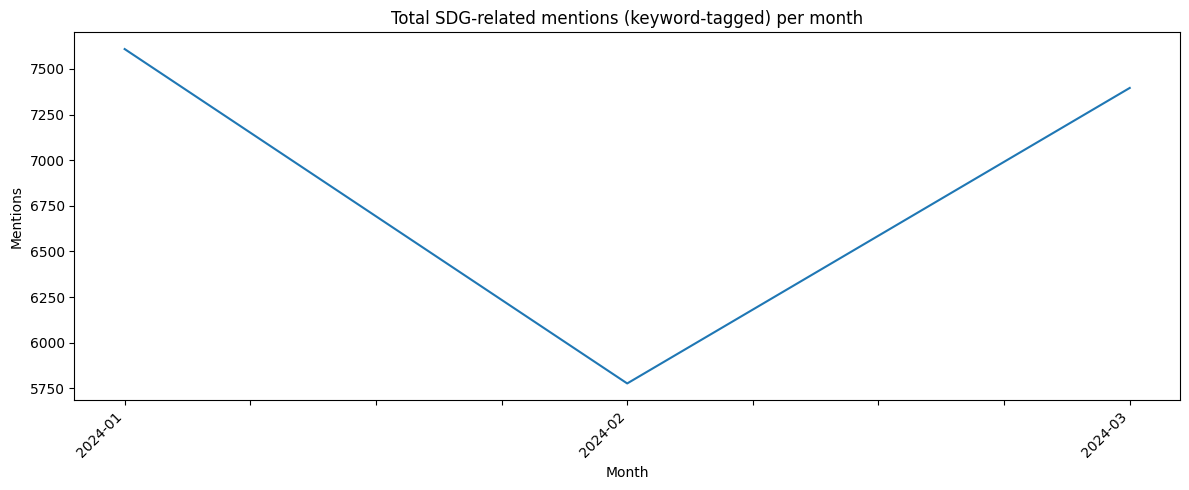

In [14]:
plt.figure(figsize=(12,5))
pivot.sum(axis=1).plot()
plt.title('Total SDG-related mentions (keyword-tagged) per month')
plt.xlabel('Month')
plt.ylabel('Mentions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
out = os.path.join(FIG_DIR, 'sdg_total_mentions_per_month.png')
plt.savefig(out, dpi=200)
out


## 2) SDG distribution by language


In [15]:
lang_sdg = (long.groupby(['lang','sdg']).size()
            .reset_index(name='count')
            .sort_values(['lang','count'], ascending=[True, False]))
lang_sdg.head(10)


,lang,sdg,count
0,afrikaans,SDG1_No_Poverty,1
1,albanian,SDG17_Partnerships,40
2,albanian,SDG3_Good_Health,1
3,albanian,SDG7_Clean_Energy,1
4,azerbaijani,SDG17_Partnerships,22
5,azerbaijani,SDG3_Good_Health,2
6,bengali,SDG17_Partnerships,1
7,bengali,SDG4_Quality_Education,1
8,bengali,SDG5_Gender_Equality,1
9,bengali,SDG6_Clean_Water,1


'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_by_language_heatmap.png'

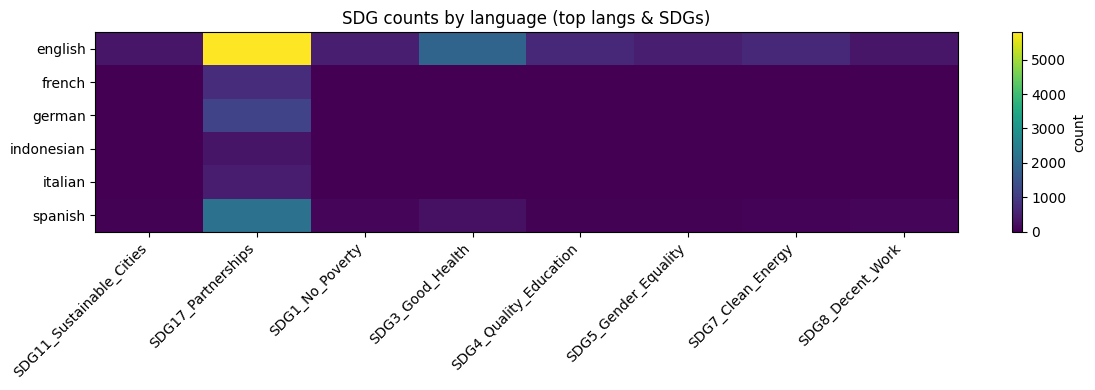

In [16]:
top_langs = lang_sdg.groupby('lang')['count'].sum().sort_values(ascending=False).head(6).index.tolist()
top_sdgs = lang_sdg['sdg'].value_counts().head(8).index.tolist()

sub = lang_sdg[lang_sdg['lang'].isin(top_langs) & lang_sdg['sdg'].isin(top_sdgs)]
heat = sub.pivot(index='lang', columns='sdg', values='count').fillna(0)

plt.figure(figsize=(12,4))
plt.imshow(heat.values, aspect='auto')
plt.yticks(range(len(heat.index)), heat.index)
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha='right')
plt.title('SDG counts by language (top langs & SDGs)')
plt.colorbar(label='count')
plt.tight_layout()
out = os.path.join(FIG_DIR, 'sdg_by_language_heatmap.png')
plt.savefig(out, dpi=200)
out


## 3) Topic modeling (baseline LDA)

We do a quick LDA over text to surface coarse themes. For multilingual data, you may prefer:
- per-language topic models, or
- translation to a pivot language, or
- embedding + clustering.


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sample = tagged.sample(min(1500, len(tagged)), random_state=42).copy()
texts = sample['text'].fillna('').tolist()

vectorizer = CountVectorizer(max_features=6000, stop_words='english')
X = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=8, random_state=42)
lda.fit(X)

vocab = np.array(vectorizer.get_feature_names_out())

def top_words(topic_idx, n=12):
    w = lda.components_[topic_idx]
    return vocab[np.argsort(w)[-n:]][::-1].tolist()

topics = {f'topic_{i}': top_words(i) for i in range(lda.n_components)}
topics


{'topic_0': ['la',
  'new',
  'en',
  'covid',
  'health',
  '2024',
  'el',
  'children',
  'state',
  'women',
  '19',
  'di'],
 'topic_1': ['la',
  'news',
  'global',
  '2024',
  'climate',
  'health',
  'world',
  'india',
  'public',
  'united',
  'new',
  'energy'],
 'topic_2': ['la',
  'climate',
  'change',
  'en',
  'new',
  'sur',
  'plan',
  'news',
  'community',
  'health',
  'le',
  'au'],
 'topic_3': ['en',
  'el',
  'la',
  'los',
  'que',
  'del',
  'se',
  'las',
  'para',
  'health',
  'una',
  'mundo'],
 'topic_4': ['covid',
  'health',
  '19',
  'launches',
  'hospital',
  'und',
  'day',
  'amid',
  'king',
  'tv',
  'procedure',
  'school'],
 'topic_5': ['solar',
  'el',
  'la',
  'que',
  'new',
  'para',
  'energy',
  'una',
  'state',
  'covid',
  'di',
  'health'],
 'topic_6': ['la',
  'el',
  '2024',
  'new',
  'poverty',
  'industry',
  'en',
  'united',
  'kingdom',
  'report',
  'oil',
  'com'],
 'topic_7': ['la',
  'climate',
  'change',
  'el',
  'en',

## 4) Simple SDG ↔ country co-occurrence network

We build an edge list where weight = count of (country, SDG) co-mentions.


In [18]:
edges = (long.groupby(['source_country','sdg']).size()
         .reset_index(name='weight')
         .dropna(subset=['source_country','sdg'])
         .sort_values('weight', ascending=False))
edges.head(10)


,source_country,sdg,weight


In [19]:
out_edges = os.path.join(PROCESSED_DIR, 'sdg_country_edges.csv')
edges.to_csv(out_edges, index=False)
out_edges


'/Users/sergey/code/sdg-multilingual-media-narratives/data/processed/sdg_country_edges.csv'

### Optional: quick visualization with NetworkX
This is kept minimal; for big graphs use Gephi or pyvis.


'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_country_network.png'

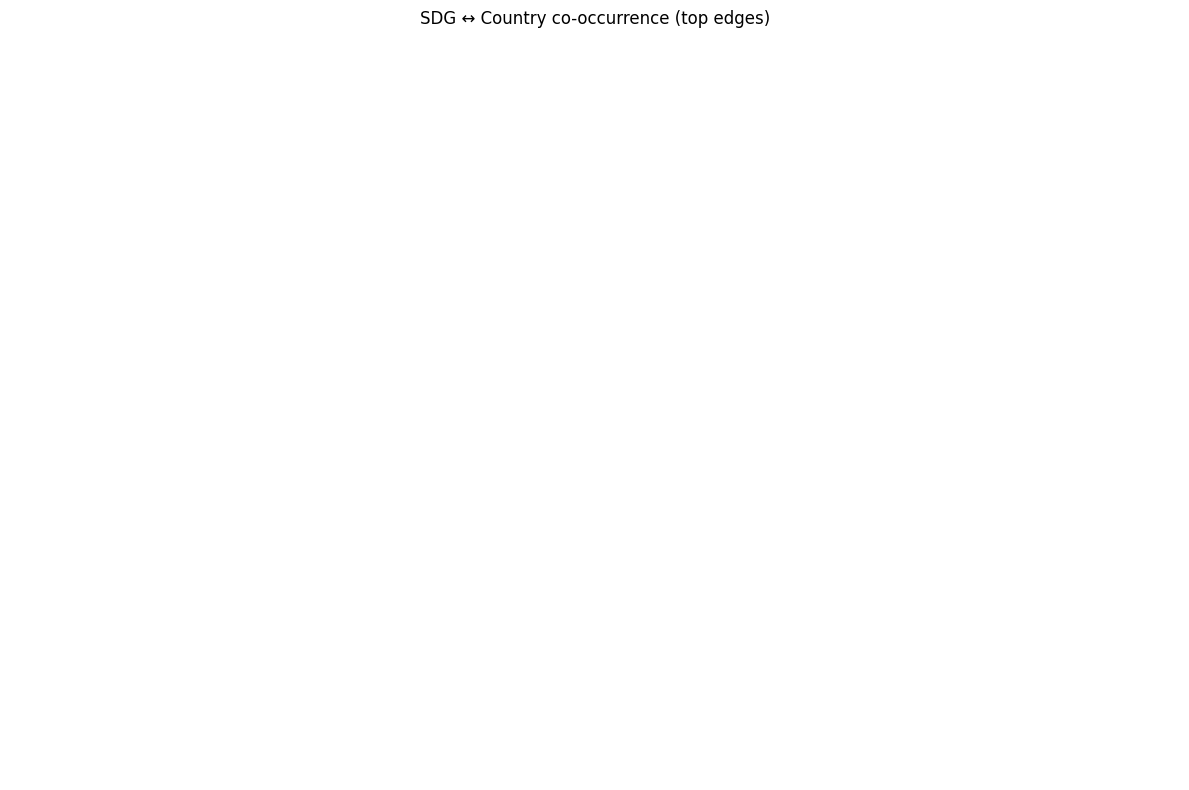

In [20]:
import networkx as nx

# take top edges to keep graph readable
top = edges.head(120)
G = nx.Graph()
for _, row in top.iterrows():
    G.add_edge(f"C:{row['source_country']}", f"S:{row['sdg']}", weight=int(row['weight']))

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.35, seed=42)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=80)
nx.draw_networkx_edges(G, pos, width=[max(0.5, math.log(w+1)) for w in weights], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.axis('off')
plt.title('SDG ↔ Country co-occurrence (top edges)')
out = os.path.join(FIG_DIR, 'sdg_country_network.png')
plt.tight_layout()
plt.savefig(out, dpi=200)
out
